In [31]:
import pandas as pd
datas = get_price(['000001.SZ'], None, '20230310', '1d', ['open', 'high','low','close','volume'], True, None, 5000, is_panel=0)

print(type(datas))

print(len(datas))

print(datas['000001.SZ'].to_csv("datas.csv"))




<class 'dict'>
1
None


In [2]:
import pandas as pd
datas = get_price(['000010.SZ'], None, '20230310', '1d', ['open', 'high','low','close','volume'], True, None, 10, is_panel=0)

print(type(datas))

print(len(datas))





<class 'dict'>
1


In [32]:
datas = pd.read_csv("datas.csv")
datas.columns=['Date','Open','High','Low','Close','Volume']
datas.to_csv('datas.csv',index=None)

In [33]:

source_code = """
def init(context):
    # 设置要操作的股票：贵州茅台
    context.security = '600519.SH'
# 设置买卖条件，每个交易频率（日/分钟/tick）调用一次
def handle_bar(context, bar_dict):
    # 获取股票过去20天的收盘价数据
    closeprice = history(context.security, ['close'], 5000, '1d', False, 'pre', is_panel=1)
    # 计算20日均线
    MA20 = closeprice['close'].mean()
    # 计算5日均线
    MA5 = closeprice['close'].iloc[-5:].mean()
    # 如果5日均线大于20日均线,则全仓买入股票
    if MA5 > MA20 :
        # 按目标市值占比下单
        order_target_percent(context.security, 1)
        # 记录这次买入
        log.info("买入 %s" % (context.security))
    # 如果5日均线小于20日均线,并且目前有头寸,则清仓股票
    elif MA20 > MA5 and context.portfolio.stock_account.market_value > 0:
        # 卖出所有股票,使这只股票的最终持有量为0
        order_target(context.security, 0)
        # 记录这次卖出
        log.info("卖出 %s" % (context.security))
"""

In [ ]:
research_strategy(
    source_code=source_code,start_date='20230101',end_date='20230220',
    capital_base=float(1000000),frequency='MINUTE',stock_market='STOCK',
    benchmark='000300.SH',plot=True
)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import talib as ta
# import os
# from models import Informer
import matplotlib.pyplot as plt


def get_attrs(df,concat=True):

    if concat == True:
        record = len(df)
        df1 = pd.read_csv("datas.csv")
        df = pd.concat([df,df1],axis=0)


    # ------------------------MA

    types=['SMA','EMA','WMA','DEMA','TEMA','TRIMA','KAMA','MAMA','T3']
    for i in range(len(types)):
        df[types[i]]=ta.MA(df['Close'],timeperiod=5,matype=i)

    # -----------------------BAND

    H_line, M_line, L_line = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['H_line'] = H_line
    df['M_line'] = M_line
    df['L_line'] = L_line

    # --------------------EMA

    N=[5,30,120,250]
    for i in N:
        df['ma_'+str(i)]=ta.EMA(df['Close'],timeperiod=i)


    # ---------------------HT
    df['dcperiod']=ta.HT_DCPERIOD(df["Close"])
    df['dcphase']=ta.HT_DCPHASE(df["Close"])
    df['inhpase'],df['quadrature']=ta.HT_PHASOR(df["Close"])
    df['sine'],df['leadsine']=sine, leadsine = ta.HT_SINE(df["Close"])
    df['trendmode']=ta.HT_TRENDMODE(df["Close"])

    # ---------------------MACD

    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    #------------------------------------MO

    df['add']=ta.ADD(df['High'],df['Low'])
    df['sub']=ta.SUB(df['High'],df['Low'])
    df['mult']=ta.MULT(df['High'],df['Low'])
    df['div']=ta.DIV(df['High'],df['Low'])
    df['sum']=ta.SUM(df['Close'], timeperiod=30)
    df['min'], df['max'] = ta.MINMAX(df['Close'], timeperiod=30)
    df['minidx'], df['maxidx'] = ta.MINMAXINDEX(df['Close'], timeperiod=30)
    df['linearreg']=ta.LINEARREG(df['Close'], timeperiod=14)
    df['tsf']=ta.TSF(df['Close'], timeperiod=14)
    df['beta']=ta.BETA(df['High'],df['Low'],timeperiod=5)
    df['correl']=ta.CORREL(df['High'],df['Low'], timeperiod=30)
    df['stdev']=ta.STDDEV(df['Close'], timeperiod=5, nbdev=1)
    df['sin']=ta.SIN(df['Close'])
    df['cos']=ta.COS(df['Close'])
    df['ln']=ta.LN(df['Close'])

    # ----------------------------------transform

    df['average']=ta.AVGPRICE(df['Open'],df['High'],df['Low'],df['Close'])
    df['median']=ta.MEDPRICE(df['High'],df['Low'])
    df['typical']=ta.TYPPRICE(df['High'],df['Low'],df['Close'])
    df['weight']=ta.WCLPRICE(df['High'],df['Low'],df['Close'])


    # --------------------------------------------VI

    df['atr']=ta.ATR(df['High'],df['Low'],df['Close'], timeperiod=14)
    df['natr']=ta.NATR(df['High'],df['Low'], df['Close'], timeperiod=14)
    df['trange']=ta.TRANGE(df['High'],df['Low'], df['Close'])

    # --------------------obv------------------

    obvta = ta.OBV(df['Close'], df['Volume'])
    obv=[]
    for i in range(0,len(df)):
        if i == 0:
            obv.append(df['Volume'].values[i])
        else:
            if df['Close'].values[i]>df['Close'].values[i-1]:
                obv.append(obv[-1]+df['Volume'].values[i])
            if df['Close'].values[i]<df['Close'].values[i-1]:
                obv.append(obv[-1]-df['Volume'].values[i])
            if df['Close'].values[i]==df['Close'].values[i-1]:
                obv.append(obv[-1])
    df['obv'] = obv

    # ------------------------RSI

    df["rsi"] = ta.RSI(df['Close'], timeperiod=14)

    df = df.fillna(0)

    if concat:
        return df.iloc[:,-record:]
    else:
        return df


def results(predict_price):
    
    predict_price = predict_price.reshape(-1,1)
    predict_price = y_stand.inverse_transform(predict_price)
    return predict_price



def create_data(datas):
    values = []
    labels = []

    x = get_datetime()
    x = x.strftime("%Y-%m-%d")
    # log.info(datas.head())
    datas.loc[len(datas)] = [0 if i != 0 else x for i in range(58) ]

    lens = datas.shape[0]
    datas = datas.values
    list1 = list(range(0,58,1))
    for index in range(0, lens - s_len): # 65-1-64
        value = datas[index:index + s_len, list1]
        label = datas[index + s_len - back_len:index + s_len + pre_len, [0, 18]]

        values.append(value)
        labels.append(label)

    return values, labels


def read_data():
    datas = pd.read_csv("./datas.csv")
    data_predict = pd.read_csv("./closeprice.csv")

    datas = pd.concat([datas,data_predict],axis=0)
    datas.fillna(0)
    
    datas = get_attrs(datas,concat=False)
    

    list1 = list(range(1,58,1))
    xs = datas.values[:, list1]
    ys = datas.values[:, 18]

    x_stand.fit(xs)
    y_stand.fit(ys[:, None])

    input_data = datas.iloc[-64:,:]

    values, labels = create_data(input_data)


    return values,labels


# 自定义数据集
class AmaData(Dataset):
    def __init__(self, values, labels):
        self.values, self.labels = values, labels

    def __len__(self):
        return len(self.values)

    def create_time(self, data):
        time = data[:, 0]
        time = pd.to_datetime(time)

        week = np.int32(time.dayofweek)[:, None]
        month = np.int32(time.month)[:, None]
        day = np.int32(time.day)[:, None]
        time_data = np.concatenate([month, week, day], axis=-1)

        return time_data

    def __getitem__(self, item):
        value = self.values[item]
        label = self.labels[item]

        value_t = self.create_time(value)
        label_t = self.create_time(label)
        value = x_stand.transform(value[:, 1:])
        label = y_stand.transform(label[:, 1][:, None])
        value = np.float32(value)
        label = np.float32(label)
        return value, label, value_t, label_t


def predict():
    test_x,test_y = read_data()  # 假设read_data函数在外部定义
    test_data = AmaData(test_x, test_y)
    test_data = DataLoader(test_data, batch_size=batch_size, shuffle=False)
     
    model = torch.load('./model.pth')  # 加载已保存的模型
    # model.eval()
    model.to(device)

    with torch.no_grad():
        for x, y, xt, yt in test_data:
            mask = torch.zeros_like(y)[:, pre_len:].to(device)

            x, y, xt, yt = x.to(device), y.to(device), xt.to(device), yt.to(device)
            dec_y = torch.cat([y[:, :pre_len], mask], dim=1)

            logits = model(x, xt, dec_y, yt)

            predict_price = results(logits)
            predict_price = predict_price[0][0]
    return predict_price


def init(context):
    # 设置要操作的股票：贵州茅台
    context.security = '000004.SZ'
        
    g.isbuy = False
    g.thefirstday = False
    g.thesecondday=False
    g.memory_true = []
    g.memory_pred = []
    g.count_trend = []
    g.penish = False
    global train_size,x_stand,y_stand,s_len,pre_len,back_len,batch_size,device,lr,epochs
    train_size = 0.85
    x_stand = StandardScaler()
    y_stand = StandardScaler()
    s_len = 64
    pre_len = 1
    back_len = 10
    batch_size = 32
    device = "cpu"
    lr = 5e-5
    epochs = 1

    
# 设置买卖条件，每个交易频率（日/分钟/tick）调用一次
def handle_bar(context, bar_dict):
    # 获取股票过去20天的收盘价数据
    closeprice = history(context.security,['open', 'high','low','close','volume'], 64, '1d', False, 'pre', is_panel=1)
    
    closeprice.to_csv('closeprice.csv')
    
    closeprice = pd.read_csv("closeprice.csv")
    closeprice.columns=['Date','Open','High','Low','Close','Volume']
    
    closeprice.to_csv('closeprice.csv',index=None)
    
    predictprice = predict()
    
    log.info("-----------------------------------------")
    log.info("真实价格："+str(closeprice.iloc[-1,-2]))
    log.info(f"预测价格：{predictprice}")
    log.info("-----------------------------------------")
    
    g.memory_true.append(closeprice.iloc[-1,-2])
    g.memory_pred.append(predictprice)
    
    if  g.thefirstday == False and g.thesecondday == False:  # 第一天不计算
        g.thefirstday = True
    
    elif g.thesecondday == False:
        g.thesecondday=True
    else:
    
        if(g.memory_pred[-2] - g.memory_pred[-3] > 0):
            log.info("模型预测下降")
        else:
            log.info("模型预测上升")
            
        if (g.memory_pred[-2] - g.memory_pred[-3])*(g.memory_true[-1] - g.memory_true[-2])> 0: # 计算预测趋势
            g.count_trend.append(1)
            log.info("趋势预测正确")
        else:
            g.count_trend.append(-1)
            log.info("趋势预测错误")
            
        if len(g.count_trend) >= 5:
            
        
            long_false = True
            long_true = True
            for i in range(-1,-6):
                if g.count_trend[i] == 1:
                    long_false = False

            for i in range(-1,-4):
                if g.count_trend[i] == -1:
                    long_true = False



            if long_false and g.penish == False:
                g.penish = True

            if long_true and g.penish == True:
                g.penish = False
              
        
        
    if g.penish == False:
        if predictprice > closeprice.iloc[-1,-2] and g.isbuy == False:
            #order_target_percent(context.security, 1)
            order_value('000001.SZ',context.portfolio.available_cash)
            log.info("买入 %s" % (context.security))
            
        elif predictprice < closeprice.iloc[-1,-2] and g.isbuy == True:
            order_target(context.security, 0)
            log.info("卖出 %s" % (context.security))
            g.isbuy = False
    else:
        print("此时正处于惩罚时间，无法预测")
        
        
    # 如果5日均线大于20日均线,则全仓买入股票
    # if MA5 > MA20 :
    #     # 按目标市值占比下单
    #     order_target_percent(context.security, 1)
    #     # 记录这次买入
    #     log.info("买入 %s" % (context.security))
    # # 如果5日均线小于20日均线,并且目前有头寸,则清仓股票
    # elif MA20 > MA5 and context.portfolio.stock_account.market_value > 0:
    #     # 卖出所有股票,使这只股票的最终持有量为0
    #     order_target(context.security, 0)
    #     # 记录这次卖出
    #     log.info("卖出 %s" % (context.security))

In [57]:
source_code="""
    import torch
    from torch import nn
    from torch.utils.data import DataLoader, Dataset
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from tqdm import tqdm
    import talib as ta
    # import os
    # from models import Informer
    import matplotlib.pyplot as plt


    def get_attrs(df,concat=True):

        if concat == True:
            record = len(df)
            df1 = pd.read_csv("datas.csv")
            df = pd.concat([df,df1],axis=0)


        # ------------------------MA

        types=['SMA','EMA','WMA','DEMA','TEMA','TRIMA','KAMA','MAMA','T3']
        for i in range(len(types)):
            df[types[i]]=ta.MA(df['Close'],timeperiod=5,matype=i)

        # -----------------------BAND

        H_line, M_line, L_line = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df['H_line'] = H_line
        df['M_line'] = M_line
        df['L_line'] = L_line

        # --------------------EMA

        N=[5,30,120,250]
        for i in N:
            df['ma_'+str(i)]=ta.EMA(df['Close'],timeperiod=i)


        # ---------------------HT
        df['dcperiod']=ta.HT_DCPERIOD(df["Close"])
        df['dcphase']=ta.HT_DCPHASE(df["Close"])
        df['inhpase'],df['quadrature']=ta.HT_PHASOR(df["Close"])
        df['sine'],df['leadsine']=sine, leadsine = ta.HT_SINE(df["Close"])
        df['trendmode']=ta.HT_TRENDMODE(df["Close"])

        # ---------------------MACD

        df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        #------------------------------------MO

        df['add']=ta.ADD(df['High'],df['Low'])
        df['sub']=ta.SUB(df['High'],df['Low'])
        df['mult']=ta.MULT(df['High'],df['Low'])
        df['div']=ta.DIV(df['High'],df['Low'])
        df['sum']=ta.SUM(df['Close'], timeperiod=30)
        df['min'], df['max'] = ta.MINMAX(df['Close'], timeperiod=30)
        df['minidx'], df['maxidx'] = ta.MINMAXINDEX(df['Close'], timeperiod=30)
        df['linearreg']=ta.LINEARREG(df['Close'], timeperiod=14)
        df['tsf']=ta.TSF(df['Close'], timeperiod=14)
        df['beta']=ta.BETA(df['High'],df['Low'],timeperiod=5)
        df['correl']=ta.CORREL(df['High'],df['Low'], timeperiod=30)
        df['stdev']=ta.STDDEV(df['Close'], timeperiod=5, nbdev=1)
        df['sin']=ta.SIN(df['Close'])
        df['cos']=ta.COS(df['Close'])
        df['ln']=ta.LN(df['Close'])

        # ----------------------------------transform

        df['average']=ta.AVGPRICE(df['Open'],df['High'],df['Low'],df['Close'])
        df['median']=ta.MEDPRICE(df['High'],df['Low'])
        df['typical']=ta.TYPPRICE(df['High'],df['Low'],df['Close'])
        df['weight']=ta.WCLPRICE(df['High'],df['Low'],df['Close'])


        # --------------------------------------------VI

        df['atr']=ta.ATR(df['High'],df['Low'],df['Close'], timeperiod=14)
        df['natr']=ta.NATR(df['High'],df['Low'], df['Close'], timeperiod=14)
        df['trange']=ta.TRANGE(df['High'],df['Low'], df['Close'])

        # --------------------obv------------------

        obvta = ta.OBV(df['Close'], df['Volume'])
        obv=[]
        for i in range(0,len(df)):
            if i == 0:
                obv.append(df['Volume'].values[i])
            else:
                if df['Close'].values[i]>df['Close'].values[i-1]:
                    obv.append(obv[-1]+df['Volume'].values[i])
                if df['Close'].values[i]<df['Close'].values[i-1]:
                    obv.append(obv[-1]-df['Volume'].values[i])
                if df['Close'].values[i]==df['Close'].values[i-1]:
                    obv.append(obv[-1])
        df['obv'] = obv

        # ------------------------RSI

        df["rsi"] = ta.RSI(df['Close'], timeperiod=14)

        df = df.fillna(0)

        if concat:
            return df.iloc[:,-record:]
        else:
            return df


    def results(predict_price):

        predict_price = predict_price.reshape(-1,1)
        predict_price = y_stand.inverse_transform(predict_price)
        return predict_price



    def create_data(datas):
        values = []
        labels = []

        x = get_datetime()
        x = x.strftime("%Y-%m-%d")
        # log.info(datas.head())
        datas.loc[len(datas)] = [0 if i != 0 else x for i in range(58) ]

        lens = datas.shape[0]
        datas = datas.values
        list1 = list(range(0,58,1))

        # log.info(f"len:{lens}")
        for index in range(0, lens - s_len-pre_len): # 65-1-64
            value = datas[index:index + s_len, list1]
            label = datas[index + s_len - back_len:index + s_len + pre_len, [0, 18]]

            values.append(value)
            labels.append(label)

        return values, labels


    def read_data():
        datas = pd.read_csv("./datas.csv")
        data_predict = pd.read_csv("./closeprice.csv")

        datas = pd.concat([datas,data_predict],axis=0)
        datas.fillna(0)

        datas = get_attrs(datas,concat=False)


        list1 = list(range(1,58,1))
        xs = datas.values[:, list1]
        ys = datas.values[:, 18]

        x_stand.fit(xs)
        y_stand.fit(ys[:, None])

        input_data = datas.iloc[-65:,:]

        #input_data = datas

        values, labels = create_data(input_data)

        #values = values[-1]

        #labels = labels[-1]


        # log.info(values)
        # log.info("******************************************88")
        # log.info(labels)

        return values,labels


    # 自定义数据集
    class AmaData(Dataset):
        def __init__(self, values, labels):
            self.values, self.labels = values, labels

        def __len__(self):
            return len(self.values)

        def create_time(self, data):
            time = data[:, 0]
            time = pd.to_datetime(time)

            week = np.int32(time.dayofweek)[:, None]
            month = np.int32(time.month)[:, None]
            day = np.int32(time.day)[:, None]
            time_data = np.concatenate([month, week, day], axis=-1)

            return time_data

        def __getitem__(self, item):
            value = self.values[item]
            label = self.labels[item]

            value_t = self.create_time(value)
            label_t = self.create_time(label)
            value = x_stand.transform(value[:, 1:])
            label = y_stand.transform(label[:, 1][:, None])


            value = np.float32(value)
            label = np.float32(label)
            return value, label, value_t, label_t


    def predict():
        test_x,test_y = read_data()  # 假设read_data函数在外部定义
        # log.info(test_x)
        # log.info(test_y)
        test_data = AmaData(test_x, test_y)
        test_data = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        model = torch.load('./model(4).pth')  # 加载已保存的模型
        # model.eval()
        model.to(device)

        with torch.no_grad():
            for x, y, xt, yt in test_data:
                # log.info("我已经入")
                mask = torch.zeros_like(y)[:, pre_len:].to(device)

                x, y, xt, yt = x.to(device), y.to(device), xt.to(device), yt.to(device)
                dec_y = torch.cat([y[:, :pre_len], mask], dim=1)

                logits = model(x, xt, dec_y, yt)

                predict_price = results(logits)
                predict_price = predict_price[0][0]

                # log.info("predict_preice is {predict_price}")

                return predict_price


    def init(context):
        context.security = '000001.SZ'

        g.isbuy = False
        g.thefirstday = False
        g.thesecondday=False
        g.memory_true = []
        g.memory_pred = []
        g.count_trend = []
        g.penish = False
        global train_size,x_stand,y_stand,s_len,pre_len,back_len,batch_size,device,lr,epochs
        train_size = 1
        x_stand = StandardScaler()
        y_stand = StandardScaler()
        s_len = 64
        pre_len = 1
        back_len = 32
        batch_size = 1
        device = "cpu"
        lr = 5e-5
        epochs = 1


    # 设置买卖条件，每个交易频率（日/分钟/tick）调用一次
    def handle_bar(context, bar_dict):
        # 获取股票过去64天的收盘价数据
        closeprice = history(context.security,['open', 'high','low','close','volume'], 64, '1d', False, 'pre', is_panel=1)

        closeprice.to_csv('closeprice.csv')

        closeprice = pd.read_csv("closeprice.csv")
        closeprice.columns=['Date','Open','High','Low','Close','Volume']

        closeprice.to_csv('closeprice.csv',index=None)

        predictprice = predict()

        log.info("-----------------------------------------")
        log.info("真实价格："+str(closeprice.iloc[-1,-2]))
        log.info(f"预测价格：{predictprice}")
        log.info("-----------------------------------------")

        g.memory_true.append(closeprice.iloc[-1,-2])
        g.memory_pred.append(predictprice)

        if  g.thefirstday == False and g.thesecondday == False:  # 第一天不计算
            g.thefirstday = True

        elif g.thesecondday == False:
            g.thesecondday=True
        else:

            if(g.memory_pred[-2] - g.memory_pred[-3] > 0):
                log.info("模型预测下降")
            else:
                log.info("模型预测上升")

            if (g.memory_pred[-2] - g.memory_pred[-3])*(g.memory_true[-1] - g.memory_true[-2])> 0: # 计算预测趋势
                g.count_trend.append(1)
                log.info("趋势预测正确")
            else:
                g.count_trend.append(-1)
                log.info("趋势预测错误")

            if len(g.count_trend) >= 5:


                long_false = True
                long_true = True
                for i in range(-1,-6):
                    if g.count_trend[i] == 1:
                        long_false = False

                for i in range(-1,-4):
                    if g.count_trend[i] == -1:
                        long_true = False



                if long_false and g.penish == False:
                    g.penish = True

                if long_true and g.penish == True:
                    g.penish = False



        if g.penish == False:
            if predictprice > closeprice.iloc[-1,-2] and g.isbuy == False:
                #order_target_percent(context.security, 1)
                order_value('000001.SZ',context.portfolio.available_cash)
                log.info("买入 %s" % (context.security))

            elif predictprice < closeprice.iloc[-1,-2] and g.isbuy == True:
                order_target(context.security, 0)
                log.info("卖出 %s" % (context.security))
                g.isbuy = False
        else:
            print("此时正处于惩罚时间，无法预测")


        # 如果5日均线大于20日均线,则全仓买入股票
        # if MA5 > MA20 :
        #     # 按目标市值占比下单
        #     order_target_percent(context.security, 1)
        #     # 记录这次买入
        #     log.info("买入 %s" % (context.security))
        # # 如果5日均线小于20日均线,并且目前有头寸,则清仓股票
        # elif MA20 > MA5 and context.portfolio.stock_account.market_value > 0:
        #     # 卖出所有股票,使这只股票的最终持有量为0
        #     order_target(context.security, 0)
        #     # 记录这次卖出
        #     log.info("卖出 %s" % (context.security))
    """

2024-01-02 09:31:00.000000 - INFO - -----------------------------------------
2024-01-02 09:31:00.000000 - INFO - 真实价格：9.39
2024-01-02 09:31:00.000000 - INFO - 预测价格：10.860363213860671
2024-01-02 09:31:00.000000 - INFO - -----------------------------------------
2024-01-02 09:31:00.000000 - INFO - 买入 000001.SZ
2024-01-03 09:31:00.000000 - INFO - -----------------------------------------
2024-01-03 09:31:00.000000 - INFO - 真实价格：9.21
2024-01-03 09:31:00.000000 - INFO - 预测价格：10.876585621931753
2024-01-03 09:31:00.000000 - INFO - -----------------------------------------
2024-01-03 09:31:00.000000 - WARN - 000001.SZ 下单股数为0,订单无效.
2024-01-03 09:31:00.000000 - INFO - 买入 000001.SZ
2024-01-04 09:31:00.000000 - INFO - -----------------------------------------
2024-01-04 09:31:00.000000 - INFO - 真实价格：9.2
2024-01-04 09:31:00.000000 - INFO - 预测价格：9.885114528320017
2024-01-04 09:31:00.000000 - INFO - -----------------------------------------
2024-01-04 09:31:00.000000 - INFO - 模型预测下降
2024-01-04 09:31

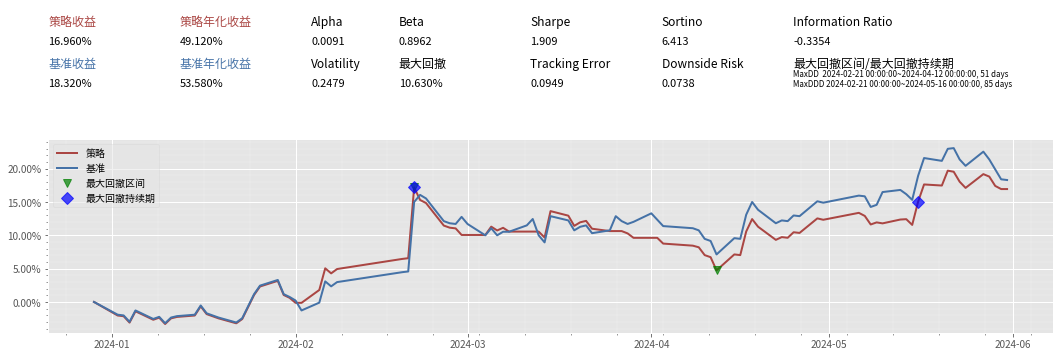

{'analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2024-01-02',
   'end_date': '2024-05-31',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.SZ',
   'STOCK': 1000000.0,
   'alpha': 0.0091,
   'beta': 0.8962,
   'sharpe': 1.9088,
   'information_ratio': -0.3354,
   'downside_risk': 0.0738,
   'tracking_error': 0.0949,
   'sortino': 6.4135,
   'volatility': 0.2479,
   'max_drawdown': 0.1063,
   'annualized_returns': 0.4912,
   'benchmark_total_returns': 0.1832,
   'benchmark_annualized_returns': 0.5358,
   'total_value': 1169584.0167,
   'cash': 1168473.0167,
   'total_returns': 0.1696,
   'unit_net_value': 1.1696,
   'units': 1000000.0},
  'trades':                         trading_datetime order_book_id     symbol  side  \
  datetime                                                                  
  2024-01-02 09:31:00  2024-01-02 09:31:00     000001.SZ  000001.SZ   BUY   
  2024-02-01 09:31:00  2024-02-01 09:31:00     000001.

In [17]:
research_strategy(
    source_code=source_code,start_date='20240101',end_date='20240601',
    capital_base=float(1000000),frequency='DAILY',stock_market='STOCK',
    benchmark='000001.SZ',plot=True
)

In [3]:
source_code="""
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import talib as ta
# import os
# from models import Informer
import matplotlib.pyplot as plt


def get_attrs(df,concat=True):

    if concat == True:
        record = len(df)
        df1 = pd.read_csv("datas.csv")
        df = pd.concat([df,df1],axis=0)


    # ------------------------MA

    types=['SMA','EMA','WMA','DEMA','TEMA','TRIMA','KAMA','MAMA','T3']
    for i in range(len(types)):
        df[types[i]]=ta.MA(df['Close'],timeperiod=5,matype=i)

    # -----------------------BAND

    H_line, M_line, L_line = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['H_line'] = H_line
    df['M_line'] = M_line
    df['L_line'] = L_line

    # --------------------EMA

    N=[5,30,120,250]
    for i in N:
        df['ma_'+str(i)]=ta.EMA(df['Close'],timeperiod=i)


    # ---------------------HT
    df['dcperiod']=ta.HT_DCPERIOD(df["Close"])
    df['dcphase']=ta.HT_DCPHASE(df["Close"])
    df['inhpase'],df['quadrature']=ta.HT_PHASOR(df["Close"])
    df['sine'],df['leadsine']=sine, leadsine = ta.HT_SINE(df["Close"])
    df['trendmode']=ta.HT_TRENDMODE(df["Close"])

    # ---------------------MACD

    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    #------------------------------------MO

    df['add']=ta.ADD(df['High'],df['Low'])
    df['sub']=ta.SUB(df['High'],df['Low'])
    df['mult']=ta.MULT(df['High'],df['Low'])
    df['div']=ta.DIV(df['High'],df['Low'])
    df['sum']=ta.SUM(df['Close'], timeperiod=30)
    df['min'], df['max'] = ta.MINMAX(df['Close'], timeperiod=30)
    df['minidx'], df['maxidx'] = ta.MINMAXINDEX(df['Close'], timeperiod=30)
    df['linearreg']=ta.LINEARREG(df['Close'], timeperiod=14)
    df['tsf']=ta.TSF(df['Close'], timeperiod=14)
    df['beta']=ta.BETA(df['High'],df['Low'],timeperiod=5)
    df['correl']=ta.CORREL(df['High'],df['Low'], timeperiod=30)
    df['stdev']=ta.STDDEV(df['Close'], timeperiod=5, nbdev=1)
    df['sin']=ta.SIN(df['Close'])
    df['cos']=ta.COS(df['Close'])
    df['ln']=ta.LN(df['Close'])

    # ----------------------------------transform

    df['average']=ta.AVGPRICE(df['Open'],df['High'],df['Low'],df['Close'])
    df['median']=ta.MEDPRICE(df['High'],df['Low'])
    df['typical']=ta.TYPPRICE(df['High'],df['Low'],df['Close'])
    df['weight']=ta.WCLPRICE(df['High'],df['Low'],df['Close'])


    # --------------------------------------------VI

    df['atr']=ta.ATR(df['High'],df['Low'],df['Close'], timeperiod=14)
    df['natr']=ta.NATR(df['High'],df['Low'], df['Close'], timeperiod=14)
    df['trange']=ta.TRANGE(df['High'],df['Low'], df['Close'])

    # --------------------obv------------------

    obvta = ta.OBV(df['Close'], df['Volume'])
    obv=[]
    for i in range(0,len(df)):
        if i == 0:
            obv.append(df['Volume'].values[i])
        else:
            if df['Close'].values[i]>df['Close'].values[i-1]:
                obv.append(obv[-1]+df['Volume'].values[i])
            if df['Close'].values[i]<df['Close'].values[i-1]:
                obv.append(obv[-1]-df['Volume'].values[i])
            if df['Close'].values[i]==df['Close'].values[i-1]:
                obv.append(obv[-1])
    df['obv'] = obv

    # ------------------------RSI

    df["rsi"] = ta.RSI(df['Close'], timeperiod=14)

    df = df.fillna(0)

    if concat:
        return df.iloc[:,-record:]
    else:
        return df


def results(predict_price):
    
    predict_price = predict_price.reshape(-1,1)
    predict_price = y_stand.inverse_transform(predict_price)
    return predict_price



def create_data(datas):
    values = []
    labels = []

    x = get_datetime()
    x = x.strftime("%Y-%m-%d")
    # log.info(datas.head())
    datas.loc[len(datas)] = [0 if i != 0 else x for i in range(6) ]


    lens = datas.shape[0]
    datas = datas.values
    for index in range(0, lens - pre_len - s_len):
        value = datas[index:index + s_len, [0, 1, 2, 3, 4, 5]]
        label = datas[index + s_len - back_len:index + s_len + pre_len, [0, 4]]

        values.append(value)
        labels.append(label)

    return values, labels


def read_data():
    datas = pd.read_csv("./datas.csv")
    data_predict = pd.read_csv("./closeprice.csv")

    datas = pd.concat([datas,data_predict],axis=0)
    datas.fillna(0)
    
    # datas = get_attrs(datas,concat=False)
    

    xs = datas.values[:, [1, 2, 3, 4, 5]]
    ys = datas.values[:, 4]

    x_stand.fit(xs)
    y_stand.fit(ys[:, None])

    input_data = datas.iloc[-65:,:]
    
    #input_data = datas
    
    values, labels = create_data(input_data)

    #values = values[-1]
    
    #labels = labels[-1]
    
    
    #log.info(values)
    #log.info("******************************************88")
    #log.info(labels)
    
    return values,labels


# 自定义数据集
class AmaData(Dataset):
    def __init__(self, values, labels):
        self.values, self.labels = values, labels

    def __len__(self):
        return len(self.values)

    def create_time(self, data):
        time = data[:, 0]
        time = pd.to_datetime(time)

        week = np.int32(time.dayofweek)[:, None]
        month = np.int32(time.month)[:, None]
        day = np.int32(time.day)[:, None]
        time_data = np.concatenate([month, week, day], axis=-1)

        return time_data

    def __getitem__(self, item):
        value = self.values[item]
        label = self.labels[item]

        value_t = self.create_time(value)
        label_t = self.create_time(label)
        value = x_stand.transform(value[:, 1:])
        label = y_stand.transform(label[:, 1][:, None])
        
        
        value = np.float32(value)
        label = np.float32(label)
        return value, label, value_t, label_t


def predict():
    test_x,test_y = read_data()  # 假设read_data函数在外部定义
    #log.info(test_x)
    #log.info(test_y)
    test_data = AmaData(test_x, test_y)
    test_data = DataLoader(test_data, batch_size=batch_size, shuffle=False)
     
    model = torch.load('./model(4).pth')  # 加载已保存的模型
    # model.eval()
    model.to(device)

    with torch.no_grad():
        for x, y, xt, yt in test_data:
            mask = torch.zeros_like(y)[:, pre_len:].to(device)

            x, y, xt, yt = x.to(device), y.to(device), xt.to(device), yt.to(device)
            dec_y = torch.cat([y[:, :pre_len], mask], dim=1)

            logits = model(x, xt, dec_y, yt)

            predict_price = results(logits)
            predict_price = predict_price[0][0]
            
            # log.info("predict_preice is {predict_price}")
            
            return predict_price


def init(context):
    context.security = '000001.SZ'
        
    g.isbuy = False
    g.thefirstday = False
    g.thesecondday=False
    g.memory_true = []
    g.memory_pred = []
    g.count_trend = []
    g.penish = False
    global train_size,x_stand,y_stand,s_len,pre_len,back_len,batch_size,device,lr,epochs
    train_size = 1
    x_stand = StandardScaler()
    y_stand = StandardScaler()
    s_len = 64
    pre_len = 1
    back_len = 32
    batch_size = 1
    device = "cpu"
    lr = 5e-5
    epochs = 1

    
# 设置买卖条件，每个交易频率（日/分钟/tick）调用一次
def handle_bar(context, bar_dict):
    # 获取股票过去64天的收盘价数据
    closeprice = history(context.security,['open', 'high','low','close','volume'], 64, '1d', False, 'pre', is_panel=1)
    
    closeprice.to_csv('closeprice.csv')
    
    closeprice = pd.read_csv("closeprice.csv")
    closeprice.columns=['Date','Open','High','Low','Close','Volume']
    
    closeprice.to_csv('closeprice.csv',index=None)
    
    predictprice = predict()
    
    log.info("-----------------------------------------")
    log.info("真实价格："+str(closeprice.iloc[-1,-2]))
    log.info(f"预测价格：{predictprice}")
    log.info("-----------------------------------------")
    
    g.memory_true.append(closeprice.iloc[-1,-2])
    g.memory_pred.append(predictprice)
    
    if  g.thefirstday == False and g.thesecondday == False:  # 第一天不计算
        g.thefirstday = True
    
    elif g.thesecondday == False:
        g.thesecondday=True
    else:
    
        if(g.memory_pred[-2] - g.memory_pred[-3] > 0):
            log.info("模型预测下降")
        else:
            log.info("模型预测上升")
            
        if (g.memory_pred[-2] - g.memory_pred[-3])*(g.memory_true[-1] - g.memory_true[-2])> 0: # 计算预测趋势
            g.count_trend.append(1)
            log.info("趋势预测正确")
        else:
            g.count_trend.append(-1)
            log.info("趋势预测错误")
            
        if len(g.count_trend) >= 5:
            
        
            long_false = True
            long_true = True
            for i in range(-1,-4):
                if g.count_trend[i] == 1:
                    long_false = False

            for i in range(-1,-4):
                if g.count_trend[i] == -1:
                    long_true = False



            #if long_false and g.penish == False:
             #   g.penish = True

            #if long_true and g.penish == True:
             #   g.penish = False
              
        
        
    if g.penish == False:
        if predictprice > closeprice.iloc[-1,-2]:
            order_target_percent(context.security,1)
            # order_value('000001.SZ',context.portfolio.available_cash)
            log.info("买入 %s" % (context.security))
            g.isbuy = True
            
        elif predictprice < closeprice.iloc[-1,-2]:
            order_target(context.security, 0.8)
            log.info("卖出 %s" % (context.security))
            g.isbuy = False
    else:
        log.info("此时正处于惩罚时间，无法预测")
        
        
    # 如果5日均线大于20日均线,则全仓买入股票
    # if MA5 > MA20 :
    #     # 按目标市值占比下单
    #     order_target_percent(context.security, 1)
    #     # 记录这次买入
    #     log.info("买入 %s" % (context.security))
    # # 如果5日均线小于20日均线,并且目前有头寸,则清仓股票
    # elif MA20 > MA5 and context.portfolio.stock_account.market_value > 0:
    #     # 卖出所有股票,使这只股票的最终持有量为0
    #     order_target(context.security, 0)
    #     # 记录这次卖出
    #     log.info("卖出 %s" % (context.security))
"""

2024-01-02 09:31:00.000000 - INFO - -----------------------------------------
2024-01-02 09:31:00.000000 - INFO - 真实价格：9.39
2024-01-02 09:31:00.000000 - INFO - 预测价格：10.415321671101253
2024-01-02 09:31:00.000000 - INFO - -----------------------------------------
2024-01-02 09:31:00.000000 - INFO - 买入 000001.SZ
2024-01-03 09:31:00.000000 - INFO - -----------------------------------------
2024-01-03 09:31:00.000000 - INFO - 真实价格：9.21
2024-01-03 09:31:00.000000 - INFO - 预测价格：11.29021996324717
2024-01-03 09:31:00.000000 - INFO - -----------------------------------------
2024-01-03 09:31:00.000000 - WARN - 000001.SZ 下单股数为0,订单无效.
2024-01-03 09:31:00.000000 - INFO - 买入 000001.SZ
2024-01-04 09:31:00.000000 - INFO - -----------------------------------------
2024-01-04 09:31:00.000000 - INFO - 真实价格：9.2
2024-01-04 09:31:00.000000 - INFO - 预测价格：10.203666007817807
2024-01-04 09:31:00.000000 - INFO - -----------------------------------------
2024-01-04 09:31:00.000000 - INFO - 模型预测下降
2024-01-04 09:31

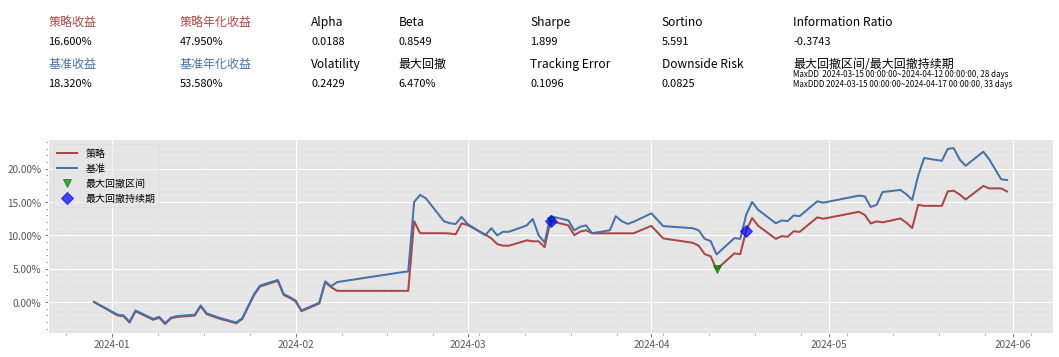

{'analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2024-01-02',
   'end_date': '2024-05-31',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.SZ',
   'STOCK': 1000000.0,
   'alpha': 0.0188,
   'beta': 0.8549,
   'sharpe': 1.8992,
   'information_ratio': -0.3743,
   'downside_risk': 0.0825,
   'tracking_error': 0.1096,
   'sortino': 5.5911,
   'volatility': 0.2429,
   'max_drawdown': 0.0647,
   'annualized_returns': 0.4795,
   'benchmark_total_returns': 0.1832,
   'benchmark_annualized_returns': 0.5358,
   'total_value': 1165968.4144,
   'cash': 529.4144,
   'total_returns': 0.166,
   'unit_net_value': 1.166,
   'units': 1000000.0},
  'trades':                         trading_datetime order_book_id     symbol  side  \
  datetime                                                                  
  2024-01-02 09:31:00  2024-01-02 09:31:00     000001.SZ  000001.SZ   BUY   
  2024-02-08 09:31:00  2024-02-08 09:31:00     000001.SZ  00

In [4]:
research_strategy(
    source_code=source_code,start_date='20240101',end_date='20240601',
    capital_base=float(1000000),frequency='DAILY',stock_market='STOCK',
    benchmark='000001.SZ',plot=True
)